In [1]:
from census import Census
from us import states
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import json
from pandas import DataFrame
import censusdata
from geopandas import GeoDataFrame
from shapely.geometry import Point

In [2]:
f = open('config/keys.json')
data = json.load(f)
acs_api_key = data['acs']['key']
c = Census(acs_api_key)

In [124]:
def get_ACS5_years(tablename, fields, geo, years):
    data = pd.DataFrame()
    for year in years:
        ndata = get_ACS5_data(tablename = tablename, 
                             fields = fields, 
                             geo = geo, 
                             year = year)
        ndata['Year'] = year
        data = data.append(ndata)
        print(tablename + ' ' + str(year))
    return(data)

In [125]:
lane_pop_years = get_ACS5_years(tablename = 'B01001', fields = '*', geo = 'blockgroup', years = range(2013, 2021))

B01001 2013
B01001 2014
B01001 2015
B01001 2016
B01001 2017
B01001 2018
B01001 2019
B01001 2020


In [126]:
print(lane_pop_years.head(2))

   B01001_001E  B01001_002E  B01001_003E  B01001_004E  B01001_005E  \
0       1595.0        786.0         26.0         36.0         76.0   
1       1089.0        520.0         24.0         38.0         24.0   

   B01001_006E  B01001_007E  B01001_008E  B01001_009E  B01001_010E  ...  \
0         46.0         21.0         12.0          0.0         33.0  ...   
1         26.0         27.0          0.0          0.0         19.0  ...   

   B01001_042E  B01001_043E  B01001_044E  B01001_045E  B01001_046E  \
0         12.0         21.0          0.0         32.0          0.0   
1          0.0         12.0         37.0         34.0         16.0   

   B01001_047E  B01001_048E  B01001_049E         GEOID  Year  
0         33.0         18.0         39.0  410390023022  2013  
1         56.0         18.0         17.0  410390007082  2013  

[2 rows x 51 columns]


In [103]:
# geo includes tract and blockgroup
def get_ACS5_data(tablename, fields, geo, year):
    if fields == "*":
        if year > 2019:
            YEAR = 2019
        else:
            YEAR = year
        fields = [key for key, value in censusdata.censustable('acs5', YEAR, tablename).items()]
    if geo == "tract":
        data = DataFrame(c.acs5.state_county_blockgroup(fields = fields,
                                      state_fips = states.OR.fips,
                                      county_fips = "039",
                                      tract = "*",
                                      year = year))
        data["GEOID"] = data["state"] + data["county"] + data["tract"]
        data = data.drop(columns = ["state", "county", "tract"])
        
    else:
        data = DataFrame(c.acs5.state_county_blockgroup(fields = fields,
                                      state_fips = states.OR.fips,
                                      county_fips = "039",
                                      blockgroup = "*",
                                      year = year))
        data["GEOID"] = data["state"] + data["county"] + data["tract"] + data["block group"]
        data = data.drop(columns = ["state", "county", "tract", "block group"])
        
    return(data)

In [104]:
lane_pop = get_ACS5_data(tablename = 'B01001', fields = '*', geo = 'blockgroup', year = 2020)

In [81]:
lane_race = get_ACS5_data(tablename = 'B03002', 
                          fields = ['B03002_001E', 'B03002_002E', 'B03002_003E'], 
                          geo = 'blockgroup', 
                          year = 2020)

In [82]:
print(lane_race.head(2))

   B03002_001E  B03002_002E  B03002_003E         GEOID
0       1678.0       1657.0       1579.0  410390004023
1       1201.0       1117.0       1033.0  410390004033


In [24]:
lane_pop = DataFrame(c.acs5.state_county_blockgroup(fields = [key for key, value in censusdata.censustable('acs5', 2019, 'B01001').items()],
                                      state_fips = states.OR.fips,
                                      county_fips = "039",
                                      blockgroup = "*",
                                      year = 2020))

In [80]:
print(lane_pop.head(2))

   B01001_001E  B01001_002E  B01001_003E  B01001_004E  B01001_005E  \
0       1678.0        869.0         26.0        231.0          0.0   
1       1201.0        618.0          0.0         44.0          0.0   

   B01001_006E  B01001_007E  B01001_008E  B01001_009E  B01001_010E  ...  \
0          0.0          0.0         12.0          0.0         20.0  ...   
1         75.0         42.0          4.0          3.0         17.0  ...   

   B01001_041E  B01001_042E  B01001_043E  B01001_044E  B01001_045E  \
0         65.0          9.0         24.0         23.0         28.0   
1         68.0         46.0         42.0          0.0         47.0   

   B01001_046E  B01001_047E  B01001_048E  B01001_049E         GEOID  
0         30.0         49.0          7.0         29.0  410390004023  
1         10.0         50.0         16.0          0.0  410390004033  

[2 rows x 50 columns]


In [32]:
lane_pop["GEOID"] = lane_pop["state"] + lane_pop["county"] + lane_pop["tract"] + lane_pop["block group"]

In [33]:
lane_pop = lane_pop.drop(columns = ["state", "county", "tract", "block group"])

In [27]:
or_bg = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2020/BG/tl_2020_41_bg.zip")

In [59]:
or_bg = or_bg.to_crs(epsg = 2914)

In [30]:
print(or_bg.head(2))

  STATEFP COUNTYFP TRACTCE BLKGRPCE         GEOID       NAMELSAD  MTFCC  \
0      41      029  000100        2  410290001002  Block Group 2  G5030   
1      41      029  000201        1  410290002011  Block Group 1  G5030   

  FUNCSTAT    ALAND  AWATER     INTPTLAT      INTPTLON  \
0        S  1593297       0  +42.3221153  -122.8685533   
1        S   557475       0  +42.3324519  -122.8862449   

                                            geometry  
0  POLYGON ((509850.965 4686522.313, 509850.934 4...  
1  POLYGON ((508852.489 4686539.079, 508855.287 4...  


In [61]:
lane_merge = or_bg.merge(lane_pop, on = "GEOID")

In [53]:
print(lane_merge.head(2))

  STATEFP COUNTYFP TRACTCE BLKGRPCE         GEOID       NAMELSAD  MTFCC  \
0      41      039  003500        4  410390035004  Block Group 4  G5030   
1      41      039  005000        3  410390050003  Block Group 3  G5030   

  FUNCSTAT    ALAND  AWATER  ... B01001_040E B01001_041E B01001_042E  \
0        S  7896443   50886  ...        30.0        53.0        24.0   
1        S  1733554       0  ...        15.0        31.0        64.0   

   B01001_043E  B01001_044E  B01001_045E  B01001_046E  B01001_047E  \
0         25.0          0.0         59.0         32.0         27.0   
1         35.0         32.0         18.0         59.0         31.0   

   B01001_048E  B01001_049E  
0          7.0          6.0  
1          0.0         15.0  

[2 rows x 62 columns]


In [54]:
print(lane_merge.columns)

Index(['STATEFP', 'COUNTYFP', 'TRACTCE', 'BLKGRPCE', 'GEOID', 'NAMELSAD',
       'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON',
       'geometry', 'B01001_001E', 'B01001_002E', 'B01001_003E', 'B01001_004E',
       'B01001_005E', 'B01001_006E', 'B01001_007E', 'B01001_008E',
       'B01001_009E', 'B01001_010E', 'B01001_011E', 'B01001_012E',
       'B01001_013E', 'B01001_014E', 'B01001_015E', 'B01001_016E',
       'B01001_017E', 'B01001_018E', 'B01001_019E', 'B01001_020E',
       'B01001_021E', 'B01001_022E', 'B01001_023E', 'B01001_024E',
       'B01001_025E', 'B01001_026E', 'B01001_027E', 'B01001_028E',
       'B01001_029E', 'B01001_030E', 'B01001_031E', 'B01001_032E',
       'B01001_033E', 'B01001_034E', 'B01001_035E', 'B01001_036E',
       'B01001_037E', 'B01001_038E', 'B01001_039E', 'B01001_040E',
       'B01001_041E', 'B01001_042E', 'B01001_043E', 'B01001_044E',
       'B01001_045E', 'B01001_046E', 'B01001_047E', 'B01001_048E',
       'B01001_049E'],
      dtype='obj

In [55]:
type(lane_merge)

geopandas.geodataframe.GeoDataFrame

Text(0.5, 1.0, 'Total population by block group in Lane County')

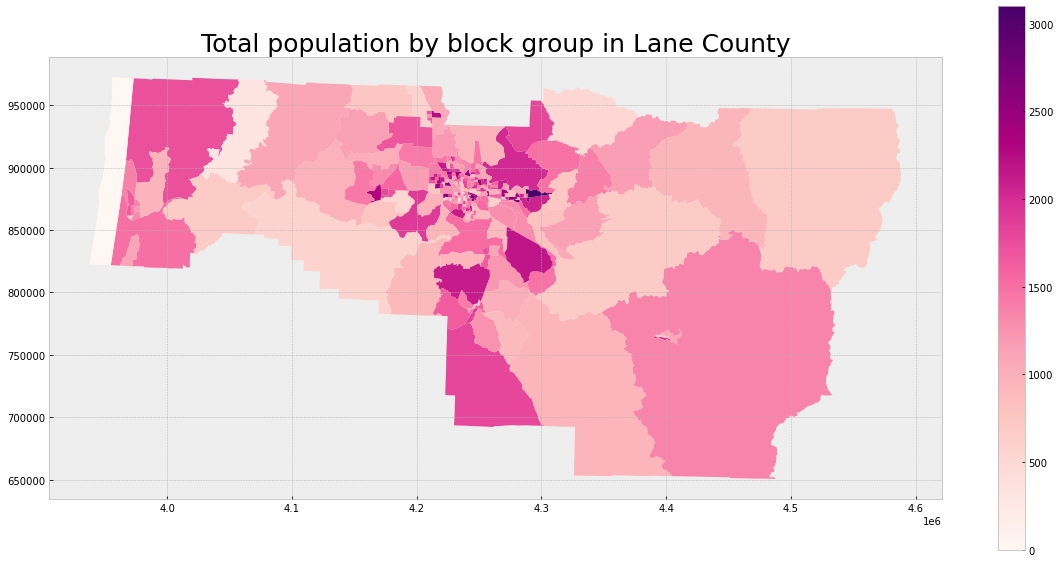

In [62]:
fig, ax = plt.subplots(1, 1, figsize = (20, 10))
lane_merge.plot(column = "B01001_001E",
                ax = ax,
                cmap = "RdPu",
                legend = True)

# Stylize plots
plt.style.use('bmh')

# Set title
ax.set_title('Total population by block group in Lane County', fontdict = {'fontsize': '25', 'fontweight' : '3'})

In [57]:
# Central Lane boundary
clb = gpd.read_file(r'T:\DCProjects\Data\Census\Shp\MPO_Boundary', layer='MPO_Boundary')

In [63]:
# Central Lane population
clpop = gpd.clip(lane_merge, clb)

Text(0.5, 1.0, 'Total population by block group in Central Lane')

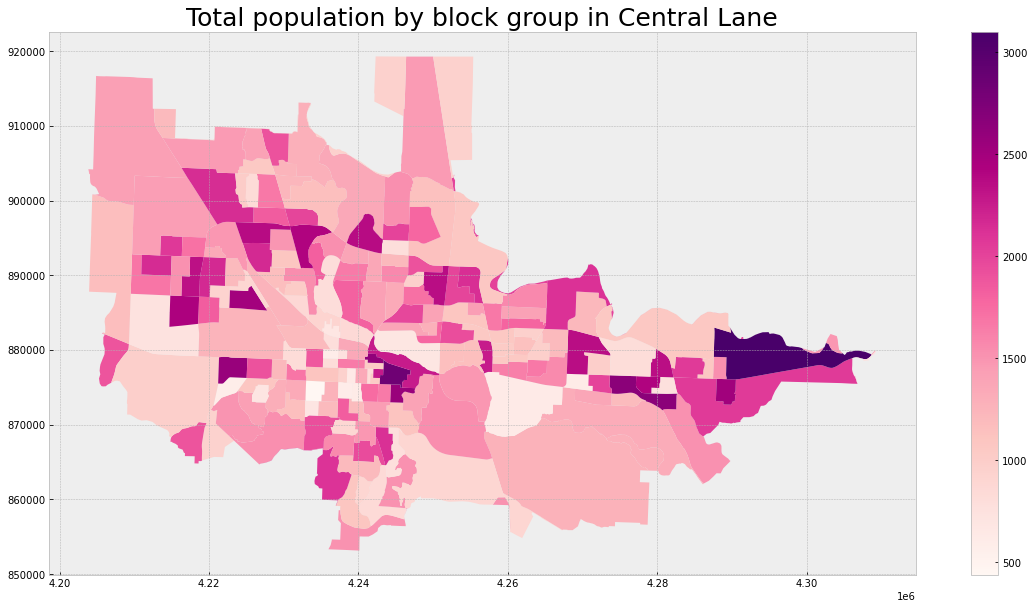

In [64]:
fig, ax = plt.subplots(1, 1, figsize = (20, 10))
clpop.plot(column = "B01001_001E",
                ax = ax,
                cmap = "RdPu",
                legend = True)

# Stylize plots
plt.style.use('bmh')

# Set title
ax.set_title('Total population by block group in Central Lane', fontdict = {'fontsize': '25', 'fontweight' : '3'})

In [3]:
countloc = pd.read_csv(r"T:\Tableau\tableauBikeCounts\Datasources\CountLocationInformation.csv")

In [4]:
print(countloc.head(2))

   OBJECTID Direction  ArrowAngle  RoadWidth  IsAutomati  DoubleCoun  \
0       198        EW           0         34       False       False   
1       199        NS          90         36       False       False   

  OnewayDire  IsSidewalk    City  \
0        NaN       False  Eugene   
1        NaN       False  Eugene   

                                          ImageFileP  ...  FacilityTy  \
0  \\clsrv111\transpor\Data\COUNTS\Nonmotorized C...  ...  NoFacility   
1  \\clsrv111\transpor\Data\COUNTS\Nonmotorized C...  ...  NoFacility   

              Location   Latitude   Longitude  IsOneway  \
0        16thWestAlder  44.042217 -123.080403     False   
1  UniversitySouth18th  44.039068 -123.074642     False   

                         Site_Name  \
0        16th Ave West of Alder St   
1  University St South of 18th Ave   

                                      Location_D HasData  TAZ  Visual  
0        16th Ave, 60ft west of Alder St, Eugene    True  395    True  
1  University St,

In [5]:
# convert dataframe to geodataframe
geometry = [Point(xy) for xy in zip(countloc.Longitude, countloc.Latitude)]
countloc_gdf = GeoDataFrame(countloc, crs="EPSG:4326", geometry=geometry)

In [6]:
countloc_gdf = countloc_gdf.to_crs(epsg = 2914)

Text(0.5, 1.0, 'Bike Counting Locations and BG Populatin in Central Lane')

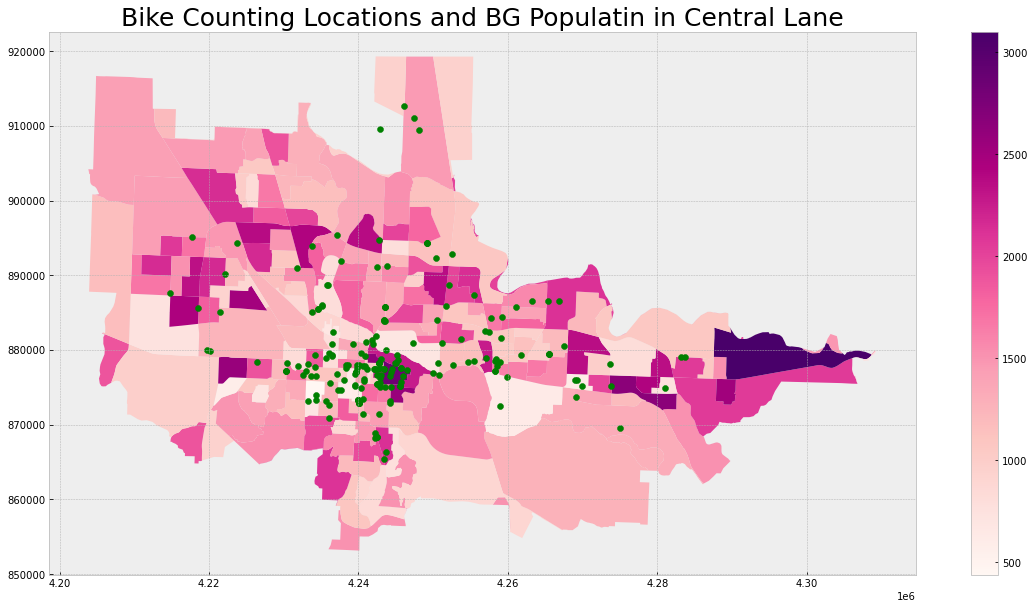

In [74]:
fig, ax = plt.subplots(1, 1, figsize = (20, 10))
clpop.plot(column = "B01001_001E",
                ax = ax,
                cmap = "RdPu",
                legend = True)
countloc_gdf.plot(ax=ax, color="green")
# Stylize plots
plt.style.use('bmh')

# Set title
ax.set_title('Bike Counting Locations and BG Populatin in Central Lane', fontdict = {'fontsize': '25', 'fontweight' : '3'})

In [110]:
from census import Census
import pandas as pd

# will get error with unknown variable
# need to specify E/M for estimate or margin of error
vars = ['B03002_003E','B11003_016E','B17010_002E']
res = []

for y in range(2014,2019+1):
    # *' is specific geoid for a block group
    lk = c.acs5.state_county_blockgroup(vars, '41', "039", "*",year=y)
    ld = pd.DataFrame(lk)
    ld['year'] = y
    res.append(ld)

combo = pd.concat(res,axis=0)
combo.head()

,B03002_003E,B11003_016E,B17010_002E,state,county,tract,block group,year
0,2425.0,54.0,42.0,41,039,001804,2,2014
1,1104.0,13.0,44.0,41,039,001001,1,2014
2,1554.0,30.0,9.0,41,039,001002,1,2014
3,988.0,16.0,22.0,41,039,001002,3,2014
4,704.0,23.0,39.0,41,039,001902,2,2014
